# Librairies

In [1]:
import pandas as pd
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pylab as plt
import geopandas as gpd

# Load Data

## Traffic counts

In [2]:
list_df = []
# read file by file 
for file in tqdm(os.listdir('raw/opendata_txt_2023/')):
    sub = pd.read_csv('raw/opendata_txt_2023/' + file, delimiter = ';', usecols = ['iu_ac', 't_1h', 'q'])
    sub.dropna(subset = ['q'], inplace=True)
    list_df.append(sub)
    
df = pd.concat(list_df)

100%|██████████| 68/68 [00:23<00:00,  2.93it/s]


In [3]:
# Memory
list_df = None
# Pre treatment
df.rename(columns={'t_1h':'time'}, inplace= True)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values(by='time')
df.reset_index(drop=True, inplace=True)
print(df.q.isna().sum())

0


In [4]:
df[(df.iu_ac == 1459) & (df.time == '2023-12-01 01:00:00')]

,iu_ac,time,q
12432620,1459,2023-12-01 01:00:00,16.0
12434054,1459,2023-12-01 01:00:00,16.0


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df

,iu_ac,time,q
0,799,2023-01-01 01:00:00,121.0
1,856,2023-01-01 01:00:00,94.5
2,5026,2023-01-01 01:00:00,394.0
3,6405,2023-01-01 01:00:00,135.0
4,5333,2023-01-01 01:00:00,3913.0
...,...,...,...
14677207,4575,2024-01-01 00:00:00,482.0
14677214,4031,2024-01-01 00:00:00,300.0
14677220,5023,2024-01-01 00:00:00,219.0
14677225,4037,2024-01-01 00:00:00,503.0


## Geographical reference

In [7]:
gdf = gpd.read_file('raw/referentiel-comptages-routiers.geojson')

In [8]:
gdf['raw_direction'] = gdf['libelle_nd_amont'] + ' --> ' +gdf['libelle_nd_aval']
gdf['raw_oneway'] = True

In [9]:
gdf[['iu_ac', 'libelle', 'geometry']]

,iu_ac,libelle,geometry
0,913,Av_Pte_Vincennes,"LINESTRING (2.41385 48.84697, 2.41321 48.84693..."
1,5221,Bd_Gouvion_St_Cyr,"LINESTRING (2.2893 48.88413, 2.28973 48.88441)"
2,852,Bd_Massena,"LINESTRING (2.36943 48.82146, 2.37167 48.82221)"
3,800,Bd_Kellermann,"LINESTRING (2.35466 48.82109, 2.35086 48.82107)"
4,863,Bd_Massena,"LINESTRING (2.38179 48.82581, 2.37949 48.82506)"
...,...,...,...
3734,564,Souterrain_Halles,"LINESTRING (2.34905 48.86386, 2.34779 48.86355..."
3735,6033,Argencon,"LINESTRING (2.31629 48.87517, 2.31575 48.87534)"
3736,269,Av_Champs_Elysees,"LINESTRING (2.3163 48.86716, 2.31477 48.86767)"
3737,214,VGP,"LINESTRING (2.34038 48.8587, 2.34091 48.85858,..."


## Map Matching with OSM

In [10]:
import contextily as cx

(2.1970939636230464, 2.4607003692409752, 48.74910266057992, 48.92261205876504)

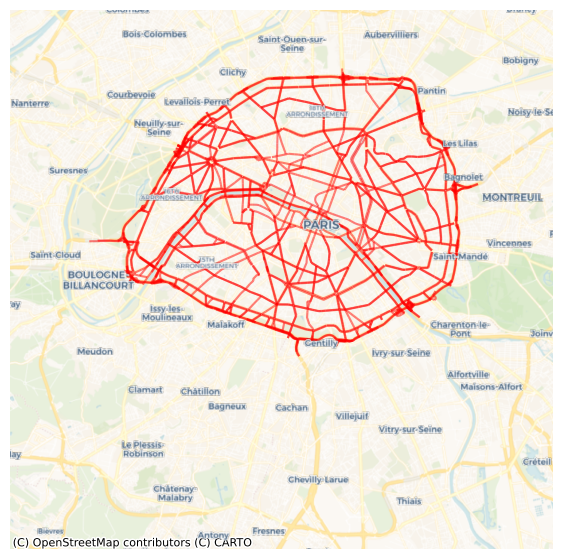

In [11]:
# Plot sensors
ax = gdf.plot(color = 'r', alpha = .5, figsize = (7,7))
# Add context in backround
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('auto')
plt.axis('off')

In [12]:
# This should be done with gdf prior to join

import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import lines_matching

In [13]:
# Convert in intergrals
gdf.iu_ac = gdf.iu_ac.astype('int')

In [14]:
# Keep only road links where we have measurements
gdf = gdf[gdf.iu_ac.isin(df.iu_ac)]

In [15]:
gdf = lines_matching(gdf, 'Paris, France')

Node 1809139821 not reachable from 1245543673
Node 1252609412 not reachable from 1245543673
Node 1809139821 not reachable from 1224181607
Node 1252609412 not reachable from 1224181607
Node 1366501892 not reachable from 1343754420
Node 1809139821 not reachable from 1343754420
Node 1311394278 not reachable from 1343754420
Node 1252609412 not reachable from 1343754420
Node 1338986231 not reachable from 1343754420
Node 1809139821 not reachable from 1245543673
Node 1252609412 not reachable from 1245543673
Node 1809139821 not reachable from 1245543673
Node 1252609412 not reachable from 1245543673
Node 1296977639 not reachable from 944554307
Node 1243705661 not reachable from 944554307
Node 1296977639 not reachable from 873319521
Node 1243705661 not reachable from 873319521
Node 1296977639 not reachable from 873319521
Node 1243705661 not reachable from 873319521
Node 1442750053 not reachable from 1243705661
Node 1758994203 not reachable from 1243705661
Node 1401657335 not reachable from 12437

In [16]:
gdf[['libelle', 'osm_name']].drop_duplicates().dropna()[:25]

,libelle,osm_name
0,Av_Pte_Vincennes,Avenue de la Porte de Vincennes
2,Bd_Massena,Boulevard Masséna
3,Bd_Kellermann,Boulevard Kellermann
4,Bd_Massena,Boulevard du Général d'Armée Jean Simon
6,Av_Champs_Elysees,Avenue des Champs-Élysées
10,Souterrain_Dauphine,Boulevard de l'Amiral Bruix
12,Bd_Haussmann,Boulevard Haussmann
13,Bd_Auguste_Blanqui,Boulevard Auguste Blanqui
18,Bd_Magenta,Boulevard de Magenta
19,Bd_de_la_Chapelle,Boulevard de la Chapelle


In [17]:
# Some sensors appear several times
gdf.drop_duplicates(subset = ['iu_ac'], inplace=True)

In [18]:
gdf.osm_oneway.value_counts()

osm_oneway
True     1023
False     447
Name: count, dtype: int64

In [19]:
gdf.raw_oneway.isna().sum()

0

In [20]:
gdf.shape

(1899, 18)

# Treatment

In [21]:
# Prepare Dataframe
df.set_index(['iu_ac', 'time'], inplace=True)

In [22]:
from temporal_agg import hourly_to_aadt

In [24]:
df, daily_capture_rate, hourly_capture_rate  = hourly_to_aadt(df, sensor_id_name='iu_ac', time_name='time', counts_name=['q'])

Hourly capture rate is 81.4 %
Daily capture rate is 81.3 %


In [26]:
df.columns = ['AADT', 'AAWT']

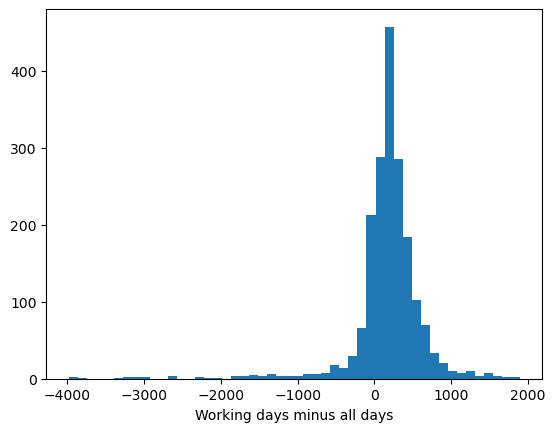

In [27]:
# Some roads are more busy during the weekends (negative values)
plt.hist((df.AAWT - df.AADT), bins = 50)
plt.xlabel('Working days minus all days')
plt.show()

In [46]:
df = df.join(
    gdf.set_index('iu_ac')[[
    'libelle', 'raw_oneway', 'raw_direction', 'osm_name', 'osm_type', 'osm_oneway', 'osm_lanes', 'osmid', 'osm_maxspeed', 'geometry'
]].rename(columns = {'libelle':'raw_name'}),
    on = 'iu_ac',
    how = 'inner'
)

df

,AADT,AAWT,raw_name,raw_oneway,raw_direction,osm_name,osm_type,osm_oneway,osm_lanes,osmid,osm_maxspeed,geometry
iu_ac,,,,,,,,,,,,
5,29072.431564,29087.669291,Quai_de_la_Megisserie,True,Pt_Neuf_Droite --> Megisserie-Bertin_Poiree,Quai de la Mégisserie,primary,True,4.0,53578234.0,30.0,"LINESTRING (2.34255 48.85846, 2.34434 48.85796)"
6,29072.431564,29087.669291,Quai_de_la_Megisserie,True,Megisserie-Bertin_Poiree --> Megisserie-Edouar...,Quai de la Mégisserie,primary,True,4.0,53578234.0,30.0,"LINESTRING (2.34434 48.85796, 2.34578 48.85753)"
7,29072.431564,29087.669291,Quai_de_la_Megisserie,True,Megisserie-Edouard_Colonne --> Chatelet,Quai de la Mégisserie,primary,True,4.0,601952770.0,30.0,"LINESTRING (2.34578 48.85753, 2.34712 48.85718)"
8,28034.970930,27916.733607,Quai_de_Gesvres,True,Chatelet --> Gesvres-Pt_Notre_Dame,Quai de Gesvres,primary,True,4.0,60184375.0,30.0,"LINESTRING (2.34712 48.85718, 2.34891 48.8567)"
9,32950.549724,32464.184109,Quai_de_Gesvres,True,Gesvres-Pt_Notre_Dame --> Gesvres-Tacherie,Quai de Gesvres,primary,True,4.0,284302748.0,30.0,"LINESTRING (2.34891 48.8567, 2.34947 48.85648)"
...,...,...,...,...,...,...,...,...,...,...,...,...
7203,5179.782670,5162.438000,Menilmontant,True,Menilmontant-Pyrenees --> Menilmontant-Pixerec...,Rue de Ménilmontant,tertiary,NaN,2.0,24044438.0,30.0,"LINESTRING (2.39455 48.86999, 2.39578 48.87007)"
7204,5179.782670,5162.438000,Menilmontant,True,Menilmontant-Pixerecourt-Chine --> Menilmontan...,Rue de Ménilmontant,tertiary,NaN,NaN,336799989.0,30.0,"LINESTRING (2.39578 48.87007, 2.39749 48.87023)"
7205,5179.782670,5162.438000,Menilmontant,True,Menilmontant-Jakubowicz --> Menilmontant-St_Fa...,Rue de Ménilmontant,tertiary,NaN,NaN,336799989.0,30.0,"LINESTRING (2.39749 48.87023, 2.39782 48.87034..."


In [29]:
from validate_dataset import validate_dataset

In [ ]:
df = validate_dataset(df)

# Final save

In [50]:
gpd.GeoDataFrame(
    df,
    geometry = 'geometry',
    crs = 'epsg:4326'
    ).to_file(
    'treated/Paris_AADT_AAWT_2023.geojson', 
    index = False
)